# Setup and Imports

In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.7 MB/s eta 0:00:00


In [2]:
!pip install shap

In [3]:
# gestión de datos
import numpy as np
import pandas as pd

# # fechas
# import datetime as dt
# from datetime import datetime
# from dateutil.relativedelta import relativedelta

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

# modelos
import sklearn
from sklearn import set_config
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier: el equivalente del Adaline
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# metricas
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve

# hiperparametrizado
from sklearn.model_selection import GridSearchCV


# interpretabilidad
import shap

# guradar modelo
import pickle

# quitar alertas
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# DF
df = pd.read_csv("/content/drive/MyDrive/TFM_EasyMoney/datasets_diccionario_TFM/df_cust_clean.csv")
df.head()

,pk_cid,active_customer,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,...,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_OTHERS,entry_channel_RED,grupo_edad_25-35,grupo_edad_35-45,grupo_edad_45-55,grupo_edad_55+
0,657826,1.0,44,54493.38,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,657817,0.0,32,103655.58,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,657986,1.0,39,100993.17,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,657905,1.0,85,154059.09,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,657336,1.0,38,105118.08,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Preprocessing

## Train / Predict

In [6]:
df_entrenar= df
df_predecir = df[df['debit_card']==0]

In [7]:
len(df_entrenar)

440244

In [8]:
len(df_predecir)

396998

In [9]:
target = 'debit_card'
df_predecir.drop(target, inplace=True, axis=1)

In [10]:
id_clientes_predecir = df_predecir['pk_cid']
df_predecir.drop(['pk_cid'], inplace=True, axis=1)
df_entrenar.drop(['pk_cid'], inplace=True, axis=1)

## Correlación

In [11]:
# df_corr = df_entrenar.corr(numeric_only=True)

# fig, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(data=df_corr, annot=True, cmap='YlGnBu')
# plt.show()

In [12]:
# Calcular correlación solo entre variables numéricas
df_corr = df_entrenar.corr(numeric_only=True)

# Crear un dataframe triangulo de las correlaciones para evitar duplicados
df_triangulo = pd.DataFrame(np.triu(df_corr, k=1), columns=df_entrenar.columns)
df_triangulo.index = df_entrenar.columns


In [13]:
# Calcular correlación solo entre variables numéricas
df_corr = df_entrenar.corr(numeric_only=True)

# Crear un dataframe triangulo de las correlaciones para evitar duplicados
df_triangulo = pd.DataFrame(np.triu(df_corr, k=1), columns=df_entrenar.columns)
df_triangulo.index = df_entrenar.columns

# Seleccionar pares de variables con correlación absoluta > 0.9
df_altas_correlaciones = df_triangulo.stack().reset_index()
df_altas_correlaciones.columns = ['variable1', 'variable2', 'correlacion']
df_altas_correlaciones = df_altas_correlaciones[df_altas_correlaciones['correlacion'].abs() > 0.9]


In [14]:
# calculamos las correlaciones de las variables con la target
corr_con_target = df_entrenar.corr()[target]

In [15]:
# añadimos las correlaciones al DataFrame de altas correlaciones
df_altas_correlaciones['corr_var1_target'] = df_altas_correlaciones['variable1'].apply(lambda x: corr_con_target[x])
df_altas_correlaciones['corr_var2_target'] = df_altas_correlaciones['variable2'].apply(lambda x: corr_con_target[x])

In [16]:
# añadimos la variable menos correlacionada con la target del par de variables altamente correlaciones
df_altas_correlaciones['var_menos_corr'] = df_altas_correlaciones.apply(
    lambda linea: linea['variable1'] if np.abs(linea['corr_var1_target']) < np.abs(linea['corr_var2_target']) else linea['variable2'], axis=1)
df_altas_correlaciones

,variable1,variable2,correlacion,corr_var1_target,corr_var2_target,var_menos_corr
409,credit_card,debt_score,0.994529,0.200567,0.201136,credit_card
443,payroll,pension_plan,0.969781,0.360057,0.369680,payroll
1103,entry_year,tenure,-0.979718,0.024754,0.004081,tenure


In [17]:
# de las variables altamentes correlacionadas, eliminamos las menos correlacionadas con la target
var_menos_corr = list(set(df_altas_correlaciones['var_menos_corr']))
var_menos_corr

['payroll', 'credit_card', 'tenure']

In [18]:
df_entrenar.drop(columns=var_menos_corr, inplace=True)
df_entrenar.head()

,active_customer,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,...,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_OTHERS,entry_channel_RED,grupo_edad_25-35,grupo_edad_35-45,grupo_edad_45-55,grupo_edad_55+
0,1.0,44,54493.38,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,32,103655.58,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,39,100993.17,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,85,154059.09,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,38,105118.08,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
df_predecir.drop(columns=var_menos_corr, inplace=True)
df_predecir.head()

,active_customer,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,...,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_OTHERS,entry_channel_RED,grupo_edad_25-35,grupo_edad_35-45,grupo_edad_45-55,grupo_edad_55+
0,1.0,44,54493.38,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,32,103655.58,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,85,154059.09,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,38,105118.08,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,62,104881.71,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
df_entrenar.shape

(440244, 40)

In [21]:
df_predecir.shape

(396998, 39)

In [22]:
# calculamos las correlaciones de las variables con la target
corr_con_target = df_entrenar.corr()[target].sort_values(ascending=False)
corr_con_target

,debit_card
debit_card,1.000000
transactions_17m,0.415100
active_customer,0.414349
payroll_account,0.399914
pension_plan,0.369680
cust_profit_17m,0.283455
debt_score,0.201136
age,0.186847
debt_income_score,0.176580
grupo_edad_35-45,0.169780


## Baja varianza

In [23]:
var_poca_varianza = []

for col in df_entrenar.columns:
  if df_entrenar[col].var() < 0.01:
    var_poca_varianza.append(col)
print(f'eliminar\n' +"\n".join(var_poca_varianza))

eliminar
short_term_deposit
loans
mortgage
funds
securities
em_account_pp
em_account_p
debt_income_score
entry_channel_KFA


In [24]:
df_entrenar.drop(columns=var_poca_varianza, inplace=True)
df_entrenar.shape

(440244, 31)

In [25]:
df_predecir.drop(columns=var_poca_varianza, inplace=True)
df_predecir.shape

(396998, 30)

# Modelado

## Feature importance

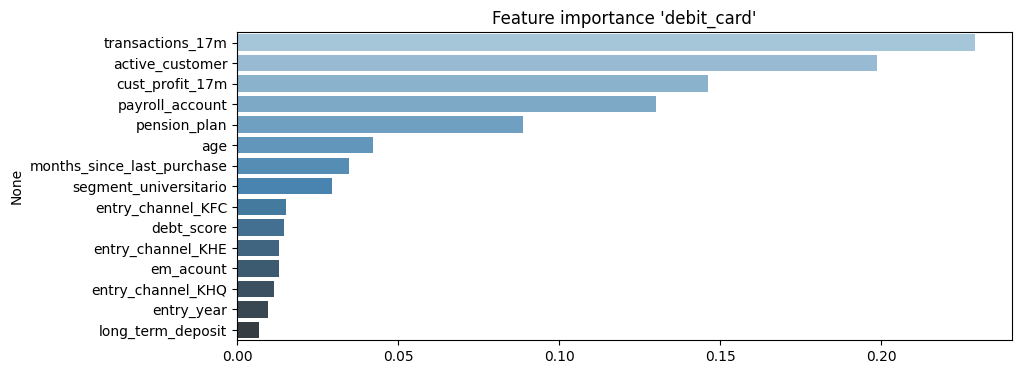

In [26]:
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

x, y = df_entrenar.drop(target,axis=1), df_entrenar[target]
# entrena un RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)

# Plotea las 15 mejores Features importances
num_features = 15
features = clf.feature_importances_
columnas = x.columns
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)[:num_features]
plt.figure(figsize=(10,4))
plt.title("Feature importance '{}'".format(target))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()

## Split train-test

In [27]:
# se guarda la target como 'y' y las features como 'X'
y = df_entrenar[target]
X = df_entrenar.drop(target, axis=1)

In [28]:
# se utilizan 70% de los datos para entrenar el modelo y se guardan 30% de los datos para evaluar el modelo (de forma aleatoria)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
print('nº observaciones de train:', len(y_train))
print('nº observaciones de test: ', len(y_test))

nº observaciones de train: 308170
nº observaciones de test:  132074


## Rebalanceo del train

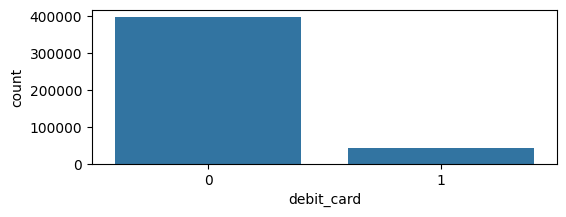

In [30]:
fig, ax = plt.subplots(figsize=(6, 2))
sns.countplot(data=df_entrenar, x=target)
plt.show()

In [31]:
# proporción de cada clase de la target
y_train.value_counts(normalize=True)

,proportion
debit_card,
0,0.901986
1,0.098014


In [32]:
X_train_0 = X_train.copy()
y_train_0 = y_train.copy()

# Crear el undersampler
undersampler = RandomUnderSampler(sampling_strategy=1.0, replacement=False, random_state=42)  # 1.0 = igualar clases

# Aplicarlo solo al conjunto de entrenamiento
X_train, y_train = undersampler.fit_resample(X_train, y_train)

## Estandarización

In [33]:
# guardo las columnas del dataset en una lista antes de standarizar
# el metodo scaler quita el nombre de las variables
# para la interpretabilidad, si el modelo ganador es un arbol de decisión, conviene guardar el nombre de las variables
variables_entrenadas = X.columns

In [34]:
# se estandarizan las variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # estandariza y define la regla de estandarización
X_test = scaler.transform(X_test)         # estandariza según la regla definida con el X_train, con la media de X_train

# se estandarizan las variables del dataset a predecir según la regla definida con el X_train
X_predecir = scaler.transform(df_predecir)

## Competición de modelos

In [35]:
# añadimos en una lista los modelos que queremos poner a competir

modelos = []
modelos.append(('SGDClassifier', SGDClassifier(loss='log_loss', random_state=42)))
modelos.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42)))
modelos.append(('XGBClassifier', XGBClassifier(random_state=42, verbosity=0)))
modelos.append(('CatBoostClassifier', CatBoostClassifier(verbose=False, random_seed=42)))
modelos.append(('LogisticRegression', LogisticRegression(random_state=42)))

In [36]:
def curva_auc(y_t, y_p):
  """imprime la curva ROC y el AUC"""

  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = metrics.roc_curve(y_t, y_p)
  roc_auc = metrics.auc(fpr, tpr)

  # para añadir el gráfico
  plt.figure(figsize=(4, 3))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

SGDClassifier(loss='log_loss', random_state=42) 0.94602501277334 0.5522815816577852


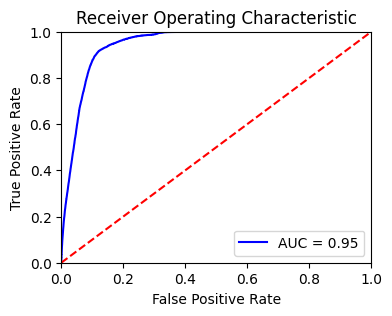

--------------------------------------------------
GradientBoostingClassifier(random_state=42) 0.9646366126095228 0.6058910806800769


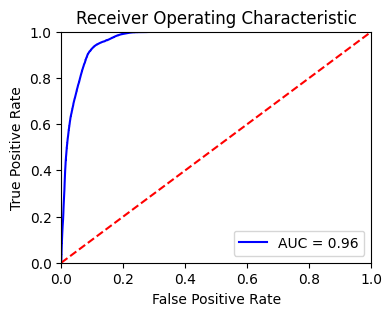

--------------------------------------------------
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) 0.9679926401886467 0.6466177119281766


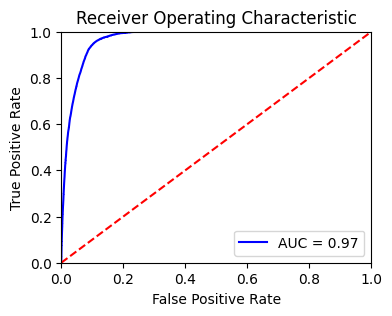

--------------------------------------------------
<catboost.core.CatBoostClassifier object at 0x7cdb37c9b6b0> 0.9690623911998035 0.6478595178719867


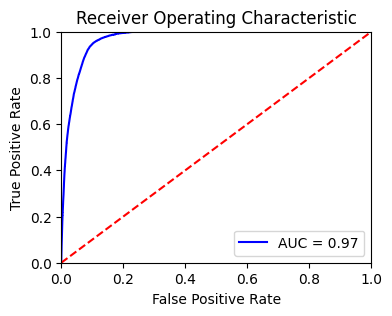

--------------------------------------------------
LogisticRegression(random_state=42) 0.946743687822127 0.5719732192672494


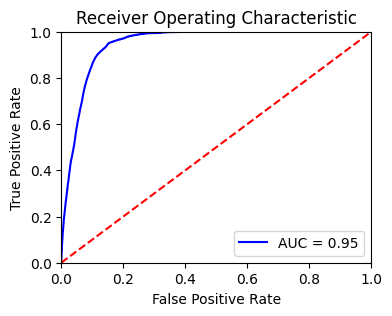

--------------------------------------------------


,modelo,AUC,F1_score
0,CatBoostClassifier,0.969062,0.647860
0,XGBClassifier,0.967993,0.646618
0,GradientBoostingClassifier,0.964637,0.605891
0,LogisticRegression,0.946744,0.571973
0,SGDClassifier,0.946025,0.552282


In [37]:
metricas_modelos = pd.DataFrame(columns=['modelo', 'AUC', 'F1_score'])

for nombre, modelo in modelos:

    # entrenamos el modelo
    modelo.fit(X_train, y_train)

    # hacemos la predicción sobre el dataset de test
    # al AUC se saca con predict_proba.
    # para el perceptron, usaremos decision_function, el equivalente del predict_proba para este algoritmo
    if nombre == 'Perceptron':
      y_pred = modelo.decision_function(X_test)
    else:
      y_pred_proba = modelo.predict_proba(X_test)[:, 1]
      y_pred= modelo.predict(X_test)

    # calculamos métricas
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    f1_score= metrics.f1_score(y_test, y_pred)


    # imprimimos el resultado por modelo
    metricas_modelos = pd.concat([metricas_modelos,
                                  pd.DataFrame({'modelo': nombre, 'AUC': auc, 'F1_score': f1_score}, index=[0])
                                  ])
    print(modelo, auc, f1_score)
    curva_auc(y_test, y_pred_proba)
    print(50*'-')

metricas_modelos.sort_values('F1_score', ascending=False)

## Hiperparametrización

In [38]:
modelo = CatBoostClassifier()

In [39]:
# parameters = {
#     'learning_rate': [0.01,0.05, 0.1], # Tasa de aprendizaje
#     'depth': [4,8],  # Profundidad de los árboles
#     'random_strength': [1,10], # Variabilidad para evitar overfitting
#     'iterations': [100, 300],  # Número de arboles

# }

In [40]:
#  grid_search = GridSearchCV(modelo,
#                            parameters,
#                            cv=2,
#                            verbose=True,
#                            scoring = 'f1')

#  grid_search.fit(X_train, y_train)

In [41]:
  # # se imprime el modelo con los mejores parametros
  # grid_search.best_params_

In [42]:

# # se introducen los parametros del griedsearch
# modelo = CatBoostClassifier(depth= 8, iterations= 300, learning_rate= 0.1, verbose= 0, random_strength= 1, random_seed=42)

# modelo.fit(X_train, y_train)
 # y_pred = modelo.predict_proba(X_test)[:, 1]

## Entrenamiento del modelo final

In [43]:
# entrenamiento
modelo =  CatBoostClassifier()
modelo.fit(X_train, y_train)

Learning rate set to 0.059356
0:	learn: 0.6014829	total: 54.8ms	remaining: 54.7s
1:	learn: 0.5295579	total: 98.4ms	remaining: 49.1s
2:	learn: 0.4706325	total: 137ms	remaining: 45.7s
3:	learn: 0.4266714	total: 181ms	remaining: 45s
4:	learn: 0.3931343	total: 233ms	remaining: 46.3s
5:	learn: 0.3665474	total: 261ms	remaining: 43.3s
6:	learn: 0.3461372	total: 289ms	remaining: 41s
7:	learn: 0.3298657	total: 317ms	remaining: 39.4s
8:	learn: 0.3161886	total: 347ms	remaining: 38.3s
9:	learn: 0.3052281	total: 372ms	remaining: 36.9s
10:	learn: 0.2962442	total: 396ms	remaining: 35.6s
11:	learn: 0.2885186	total: 419ms	remaining: 34.5s
12:	learn: 0.2824915	total: 440ms	remaining: 33.4s
13:	learn: 0.2763110	total: 464ms	remaining: 32.6s
14:	learn: 0.2713320	total: 493ms	remaining: 32.4s
15:	learn: 0.2668467	total: 539ms	remaining: 33.1s
16:	learn: 0.2634586	total: 579ms	remaining: 33.5s
17:	learn: 0.2592492	total: 623ms	remaining: 34s
18:	learn: 0.2547888	total: 670ms	remaining: 34.6s
19:	learn: 0.25

In [44]:
# predict
y_pred_train = modelo.predict(X_train)
y_pred_test = modelo.predict(X_test)

In [45]:
y_pred_proba_train = modelo.predict_proba(X_train)
y_pred_proba_test = modelo.predict_proba(X_test)

# Evalucación del modelo final

## AUC

Calcular el AUC con el predict_proba

In [46]:
# predict_proba
auc_train = metrics.roc_auc_score(y_train, y_pred_proba_train[:,1])
print('auc train:', auc_train)

auc_test = metrics.roc_auc_score(y_test, y_pred_proba_test[:,1])
print('auc test:', auc_test)

auc train: 0.9828765264868732
auc test: 0.9691126392382177


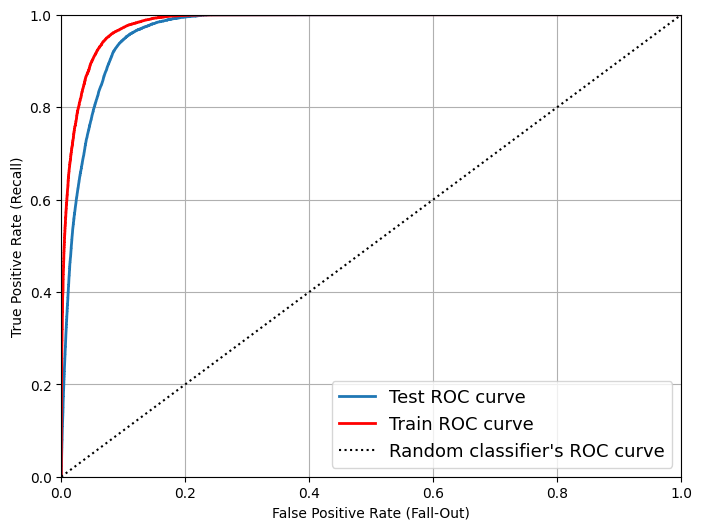

In [47]:
# Visualizacion de la ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, modelo.predict_proba(X_train)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label="Test ROC curve")
plt.plot(fpr_train, tpr_train, linewidth=2, label="Train ROC curve", color='r')
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")

plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

## matriz de confusión

In [48]:
# creamos la matriz de confusión
cm_test = metrics.confusion_matrix(y_test, y_pred_test)

[]

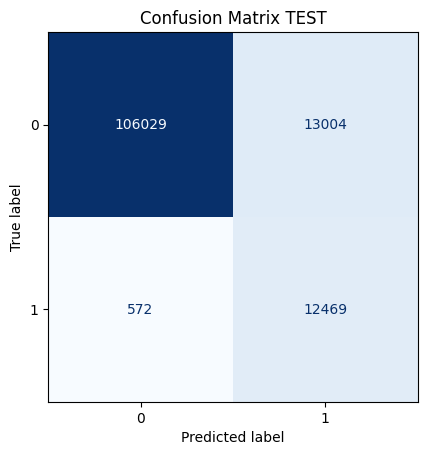

In [49]:
# gráfico de la matriz de confusión en cantidades
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(colorbar = False, cmap = 'Blues')

plt.title('Confusion Matrix TEST')
plt.plot()

## f1_score

In [50]:
accuracy_sklearn = metrics.accuracy_score(y_test, y_pred_test)
precision_sklearn = metrics.precision_score(y_test, y_pred_test)
recall_sklearn = metrics.recall_score(y_test, y_pred_test)
f1_score_sklearn = metrics.f1_score(y_test, y_pred_test)

In [51]:
print('accuracy:', round(accuracy_sklearn,4))
print('precision:', round(precision_sklearn, 4))
print('recall:', round(recall_sklearn, 4))
print('f1_score:', round(f1_score_sklearn, 4))

accuracy: 0.8972
precision: 0.4895
recall: 0.9561
f1_score: 0.6475


# Guardado del modelo

In [52]:
# Scaler: Estandarización de variables
with open('scaler.pkl', 'wb') as f:
     pickle.dump(scaler, f)

# modelo: Predicción
with open('modelo_final.pkl', 'wb') as f:
    pickle.dump(modelo, f)


# Interpretabilidad

## Modelo de árbol de decisión

In [53]:
# DF para facilitar interpretabilidad
df_X_test = pd.DataFrame(X_test, columns=variables_entrenadas)
df_X_test

,active_customer,age,salary,long_term_deposit,pension_plan,payroll_account,emc_account,em_acount,segment_universitario,big_region,...,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_OTHERS,entry_channel_RED,grupo_edad_25-35,grupo_edad_35-45,grupo_edad_45-55,grupo_edad_55+
0,0.723988,-1.015636,-0.159931,-0.124495,-0.398539,-0.481223,-0.337669,0.724094,1.028787,-1.770148,...,-0.233051,-0.31895,-0.251658,2.865353,-0.147658,-0.163668,-0.650322,-0.518740,-0.341248,-0.269412
1,0.723988,2.150210,0.167425,-0.124495,-0.398539,-0.481223,-0.337669,0.724094,-0.972019,0.564924,...,-0.233051,-0.31895,-0.251658,-0.348997,6.772428,-0.163668,-0.650322,-0.518740,-0.341248,3.711792
2,0.723988,0.770226,0.139087,-0.124495,-0.398539,-0.481223,2.961476,0.724094,-0.972019,0.564924,...,-0.233051,-0.31895,-0.251658,-0.348997,-0.147658,-0.163668,-0.650322,1.927749,-0.341248,-0.269412
3,-1.381239,-0.528583,1.164528,-0.124495,-0.398539,-0.481223,-0.337669,-1.381037,1.028787,0.564924,...,-0.233051,-0.31895,-0.251658,-0.348997,-0.147658,-0.163668,1.537700,-0.518740,-0.341248,-0.269412
4,0.723988,0.201997,-0.011973,8.032472,-0.398539,-0.481223,2.961476,-1.381037,-0.972019,0.564924,...,-0.233051,-0.31895,-0.251658,-0.348997,-0.147658,-0.163668,-0.650322,1.927749,-0.341248,-0.269412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132069,0.723988,1.257279,-0.082335,-0.124495,-0.398539,-0.481223,2.961476,0.724094,-0.972019,0.564924,...,-0.233051,-0.31895,-0.251658,-0.348997,-0.147658,-0.163668,-0.650322,-0.518740,2.930421,-0.269412
132070,-1.381239,-0.853285,0.050651,-0.124495,-0.398539,-0.481223,-0.337669,-1.381037,1.028787,0.564924,...,-0.233051,-0.31895,-0.251658,-0.348997,-0.147658,-0.163668,-0.650322,-0.518740,-0.341248,-0.269412
132071,0.723988,0.607875,-0.002625,-0.124495,-0.398539,2.078040,-0.337669,-1.381037,-0.972019,0.564924,...,-0.233051,-0.31895,-0.251658,-0.348997,-0.147658,-0.163668,-0.650322,1.927749,-0.341248,-0.269412
132072,-1.381239,-0.609759,-0.072089,-0.124495,-0.398539,-0.481223,-0.337669,0.724094,1.028787,0.564924,...,-0.233051,-0.31895,-0.251658,-0.348997,-0.147658,-0.163668,1.537700,-0.518740,-0.341248,-0.269412


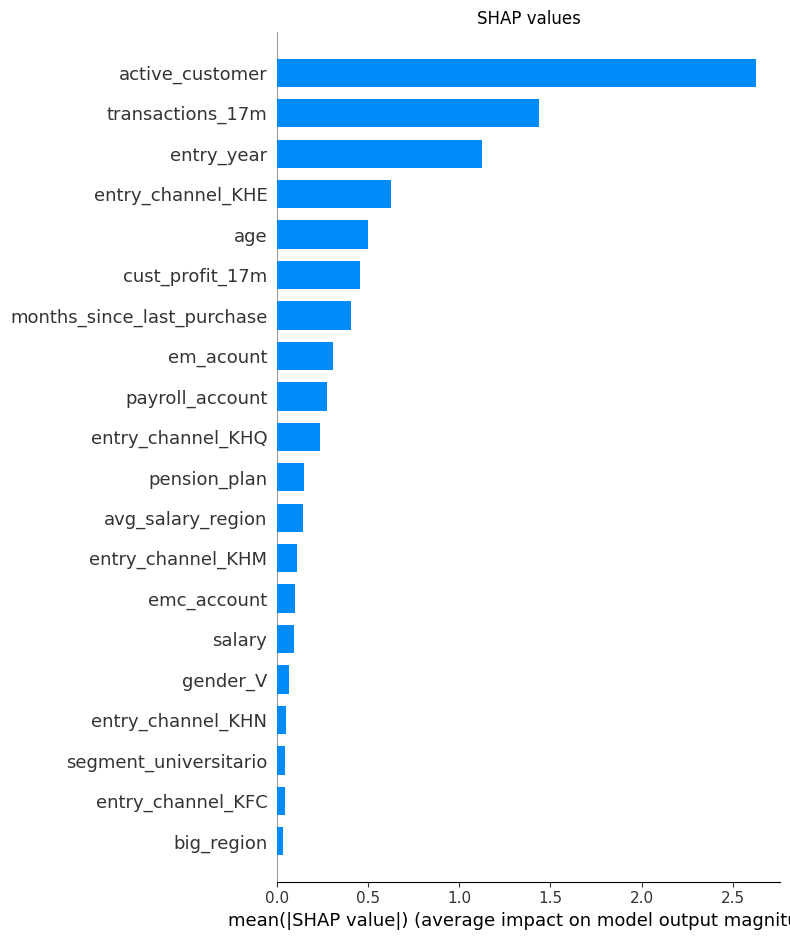

In [54]:
#SHAP value: peso en el output final
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, df_X_test, plot_type="bar", max_display=20)

### Summary_plot

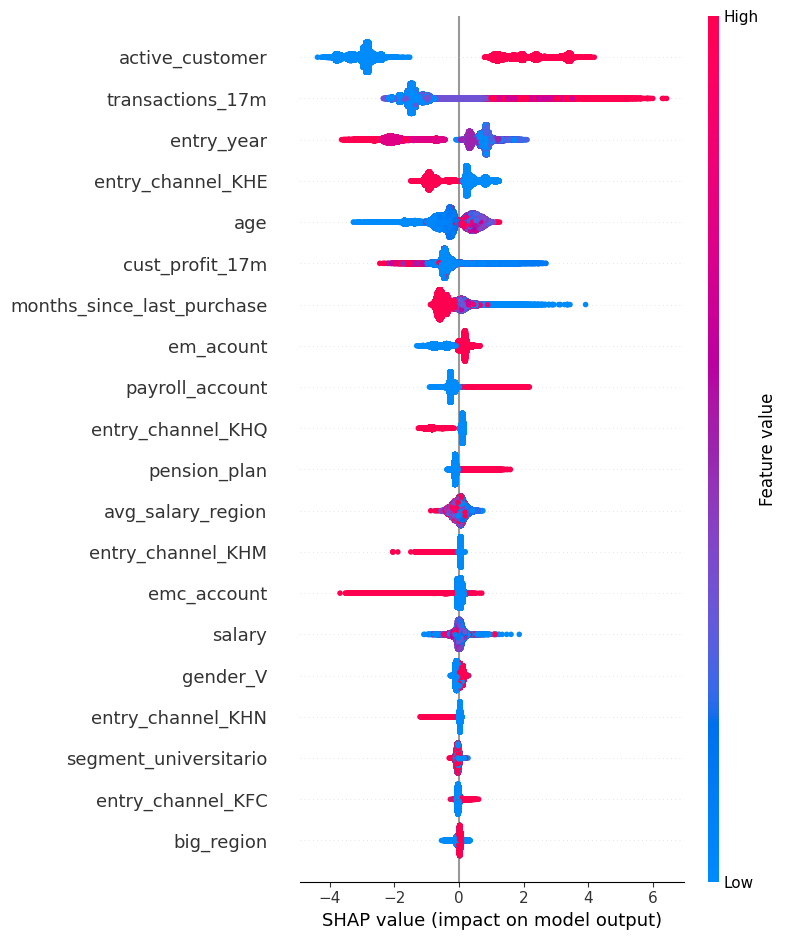

In [55]:
shap.summary_plot(shap_values, df_X_test)

# Predicción

In [56]:
#cargar modelo final
with open('modelo_final.pkl', 'rb') as f:
    pickle.load(f)

In [57]:
predict = modelo.predict(X_predecir)
predict_proba = modelo.predict_proba(X_predecir)[:,1]

In [58]:
predict

array([1, 0, 0, ..., 0, 0, 0])

In [59]:
predict_proba

array([6.57267149e-01, 6.06847768e-05, 1.39142851e-01, ...,
       2.51531255e-01, 1.68541786e-04, 3.30157523e-02])

Lista Clientes más Propensos a Compra de **em_account**

In [60]:
df_prediccion = pd.DataFrame()
df_prediccion['pk_id']= id_clientes_predecir
df_prediccion['predict']= predict
df_prediccion['predict_proba']= predict_proba

df_prediccion.sort_values('predict_proba', ascending= False)

,pk_id,predict,predict_proba
239332,1067738,1,9.990122e-01
366711,1258298,1,9.989749e-01
404900,1134917,1,9.988117e-01
336192,1216841,1,9.985913e-01
53043,1370845,1,9.985492e-01
...,...,...,...
161687,1544969,0,1.048952e-06
173404,1533669,0,1.048952e-06
172850,1532972,0,1.048952e-06
151397,1542968,0,1.032618e-06


In [61]:
print(f"Clientes Potenciales:  {len(df_prediccion[df_prediccion['predict']==1])}")
print(f"Porcentaje de la BD de Clientes:  {len(df_prediccion[df_prediccion['predict']==1]) / len(df_prediccion) * 100} %")

Clientes Potenciales:  42492
Porcentaje de la BD de Clientes:  10.703328480244233 %


In [62]:
print(f"Clientes Potenciales:  {len(df_prediccion[(df_prediccion['predict'] == 1) & (df_prediccion['predict_proba'] > 0.85)])}")
print(f"Porcentaje de la BD de Clientes:  {len(df_prediccion[(df_prediccion['predict'] == 1) & (df_prediccion['predict_proba'] > 0.85)]) / len(df_prediccion) * 100:.2f} %")

Clientes Potenciales:  17620
Porcentaje de la BD de Clientes:  4.44 %


# Exportar predicción

In [63]:
df_prediccion_export_csv = df_prediccion.copy()
df_prediccion_export_csv.to_csv('df_prediccion_debit_card.csv', index=False)